In [3]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
from datetime import datetime
import linearmodels as lm
import statsmodels.api as sm

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [5]:
cleansed=load_amihud_markets_price()

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:162: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud =\frac{1}{N} \sum \frac{|r_t|}{\text{dvol}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [6]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:48: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=250,min_periods=100,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:48: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mea

In [7]:
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')
#data=calc_zscore_rolling_window(amihud.dropna(how='all')).dropna(how='all')

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:275: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:275: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


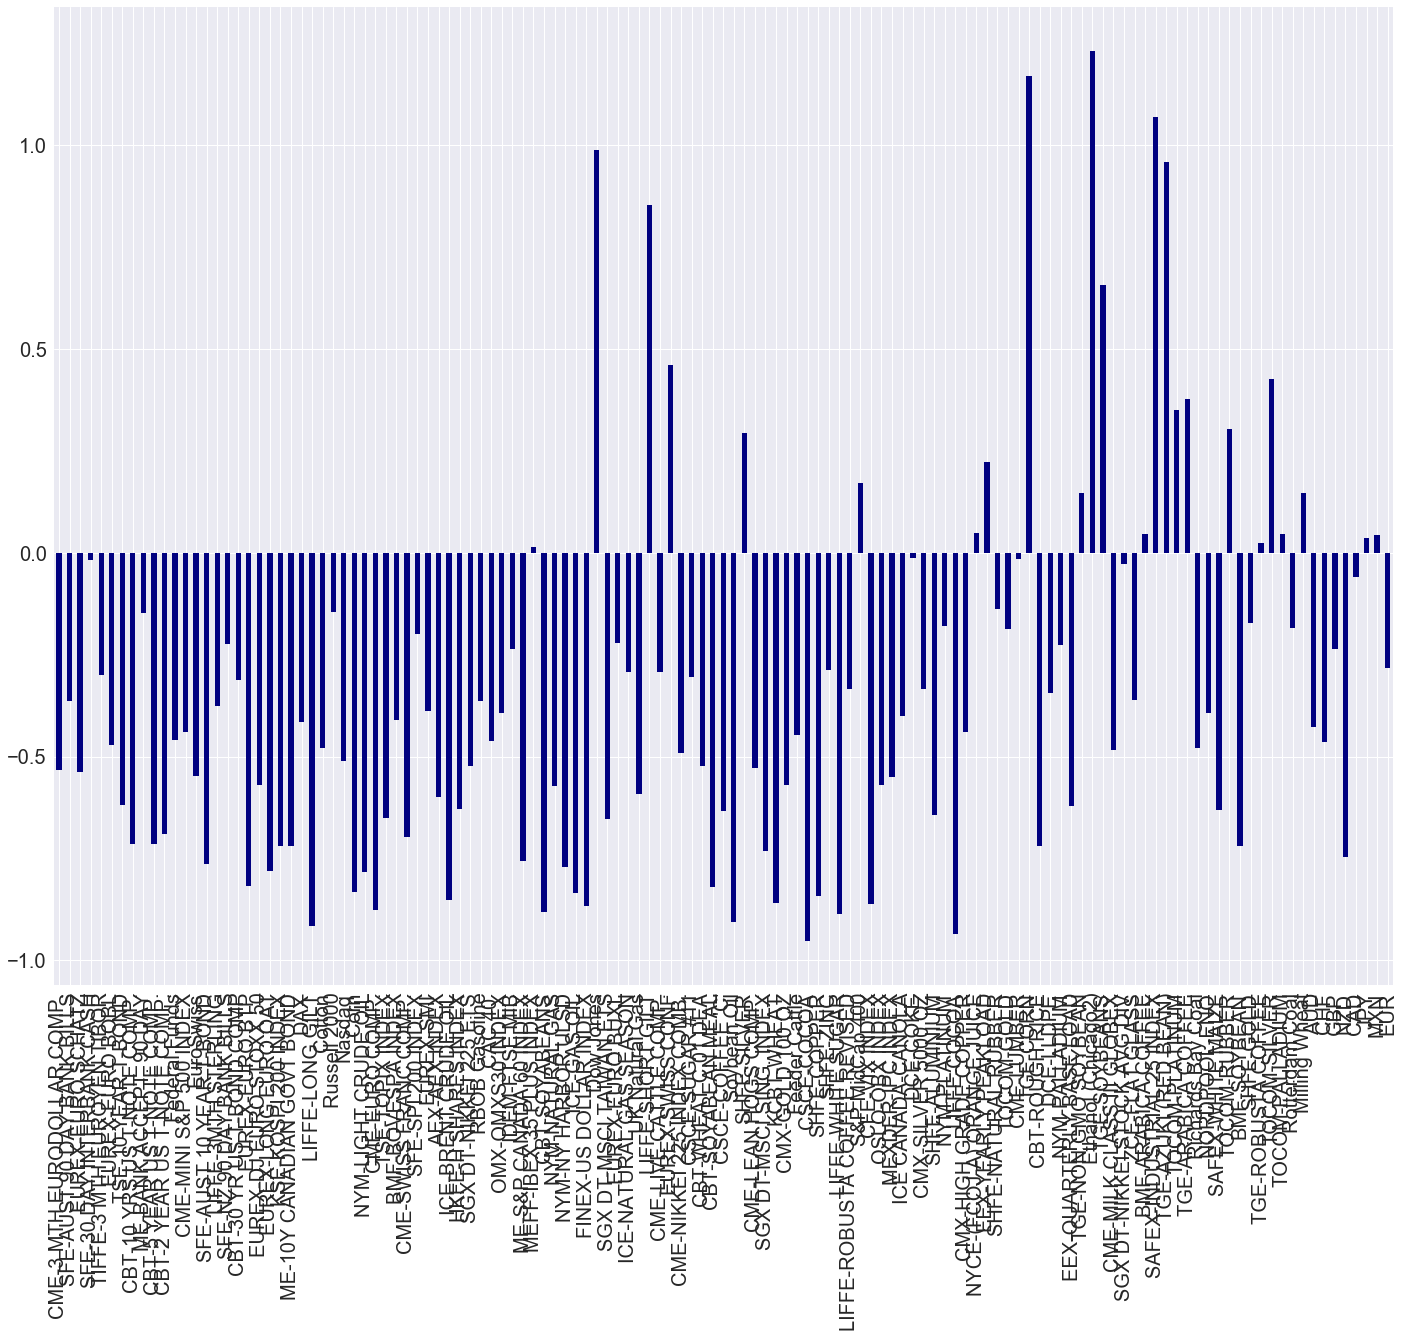

In [9]:
data['2000':'2016'].mean().plot(kind='bar',colormap='jet')

In [10]:
full_std=((amihud['2001':'2016']-amihud['2001':'2016'].mean())/amihud['2001':'2016'].std())

In [11]:
mkt = cleansed.mean(axis=1).resample(rule='m',how='last').pct_change()
pct_rtn = cleansed.resample(rule='m',how='last').pct_change()
betas=pd.DataFrame()
tstats=pd.DataFrame()
for m in data.columns:
    #if data[m].count()<36:
    #    print(m)
    #    continue
    ind = data[m].dropna()['2000':'2016'].index
    df = pd.DataFrame()
    df['Liquidity']=data[m].dropna()['2000':'2016']
   
    #ind = full_std[m].dropna()['2000':'2016'].index
    #df = pd.DataFrame()
    #df['Liquidity']=full_std[m].dropna()['2000':'2016']
    df['Market']=mkt
    #df['Value']=get_aqr_factors('All').VAL
    #df['Momentum']=get_aqr_factors('All').MOM
    res=sm.OLS(pct_rtn[m].ix[ind],sm.add_constant(df)).fit()
    betas[m]=res.params
    tstats[m]=res.tvalues

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [25]:
tstats.T.mean()

const        0.427026
Liquidity   -0.564913
Market       2.355725
dtype: float64

In [24]:
q=betas.T.Liquidity
q.sort_values()

ICE-GAS OIL                    -0.040986
ICE-BRENT CRUDE OIL            -0.038097
NYM-LIGHT CRUDE OIL            -0.034591
MEXDER-IPC INDEX               -0.033554
KSE-KOSPI 200 INDEX            -0.032730
TOCOM-SILVER                   -0.032451
BMF-SOYBEAN                    -0.028996
DCE-LLDPE                      -0.025438
EUREX-LONG EURO OAT            -0.025400
CAC 40                         -0.024676
OSLO-OBX INDEX                 -0.024416
SAFEX-WHITE MAIZE              -0.024370
DAX                            -0.023794
ME-S&P CANADA 60 INDEX         -0.021945
Russell 2000                   -0.020533
IDEM-FTSE MIB                  -0.019942
AEX-AEX INDEX                  -0.019133
CME-LEAN HOGS COMP.            -0.018991
NYM-NY HARBOR ULSD             -0.017888
EUREX-SMI                      -0.017708
TOCOM-PALLADIUM                -0.016774
EUREX-DJ EURO STOXX 50         -0.016470
CBT-SOYABEANS                  -0.015705
SHFE-ZINC                      -0.015220
SGX DT-MSCI SING

In [14]:
reg=betas.T[['Liquidity','Market']]

In [213]:
#res1=sm.OLS(pct_rtn['2000':'2016'].median(),sm.add_constant(reg)).fit()
res1=sm.OLS(pct_rtn['2000':'2016'].mean(),sm.add_constant(reg)).fit()

In [214]:
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     17.41
Date:                Thu, 12 Jul 2018   Prob (F-statistic):           2.17e-07
Time:                        16:42:48   Log-Likelihood:                 517.96
No. Observations:                 127   AIC:                            -1030.
Df Residuals:                     124   BIC:                            -1021.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.000      8.235      0.0

# Correcting the way I perform the second step

Second stage is cross sectional regression across time periods using estimated 

In [293]:
lambdas=pd.DataFrame()
for i in pct_rtn['2000':'2016'].index:
    ind=pct_rtn.ix[i].dropna().index
    res2=sm.OLS(pct_rtn.ix[i].T[ind],sm.add_constant(reg.loc[ind])).fit()
    lambdas[i]=res2.params

In [294]:
lambdas.T.mean()

const        0.003359
Liquidity    0.144467
Market       0.006170
dtype: float64

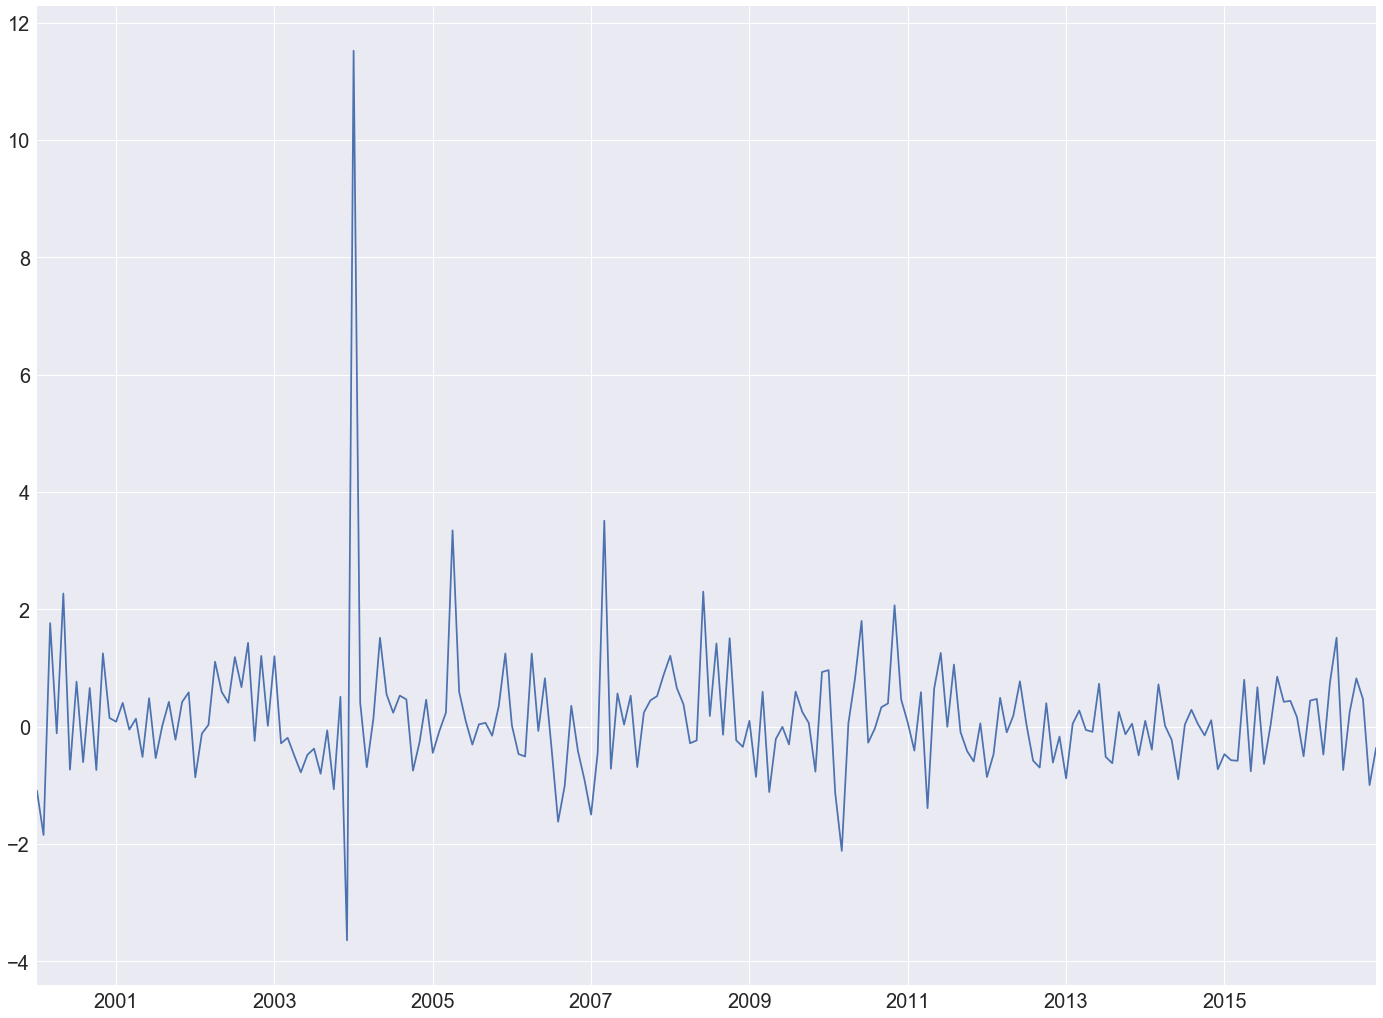

In [295]:
lambdas.T.Liquidity.plot()

# FHT method

In [296]:
FHT=calculate_FHT(cleansed)
data_FHT=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:285: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:286: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:287: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:287: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(

In [299]:
betas_FHT=pd.DataFrame()
tstats_FHT=pd.DataFrame()
for m in data.columns:
    ind = data_FHT[m].dropna()['2000':'2016'].index
    df = pd.DataFrame()
    df['Liquidity']=data_FHT[m].dropna()['2000':'2016']
    df['Market']=mkt
    res=sm.OLS(pct_rtn[m].ix[ind],sm.add_constant(df)).fit()
    betas_FHT[m]=res.params
    tstats_FHT[m]=res.tvalues

In [306]:
reg_FHT=betas_FHT.T[['Liquidity','Market']]

In [307]:
lambdas_FHT=pd.DataFrame()
for i in pct_rtn['2000':'2016'].index:
    ind=pct_rtn.ix[i].dropna().index
    res2=sm.OLS(pct_rtn.ix[i].T[ind],sm.add_constant(reg_FHT.loc[ind])).fit()
    lambdas_FHT[i]=res2.params

In [308]:
lambdas_FHT.T.mean()

const        0.003431
Liquidity    0.072034
Market       0.007166
dtype: float64

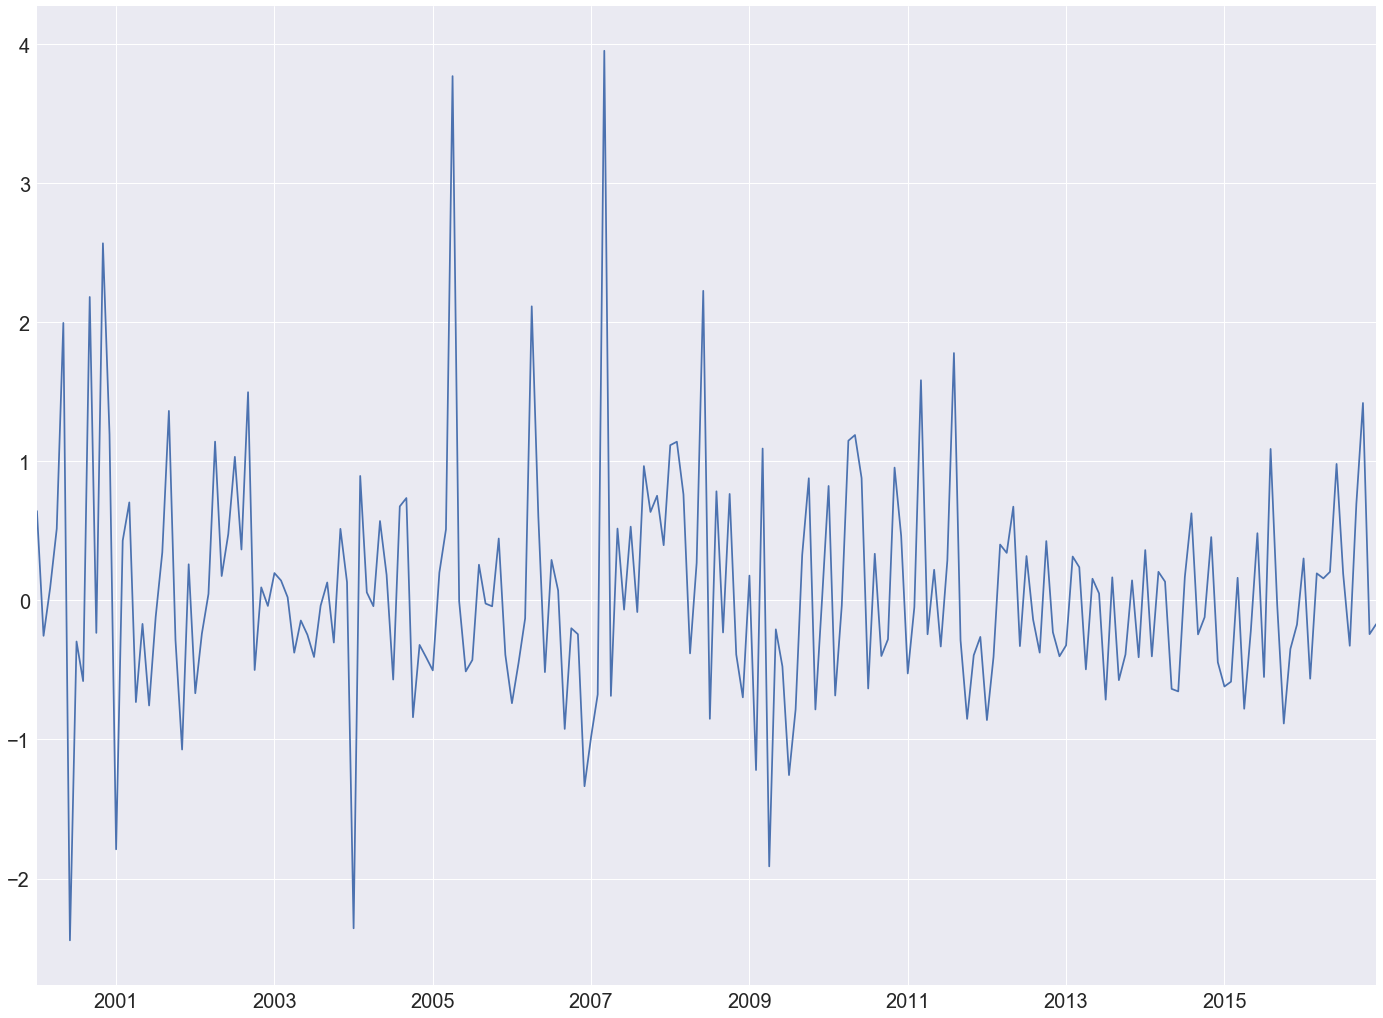

In [311]:
lambdas_FHT.T.Liquidity.plot()

# Presentation
First rsquares of residuals

In [313]:
res_lam=pd.DataFrame()
res_lam['Amihud']=lambdas.T.mean()
res_lam['FHT']=lambdas_FHT.T.mean()

In [315]:
res_lam.round(2)

,Amihud,FHT
const,0.00,0.00
Liquidity,0.14,0.07
Market,0.01,0.01


$$ r_{it} = \alpha + \lambda_{LIQ} \hat{\beta}_{LIQ}+ \lambda_{MKT} \hat{\beta}_{MKT} + \eta_{it}$$